In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy

C:\Users\kusljic\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Prvo ćemo definisati konstante koje ćemo koristiti za prediktovane klase, kao i za hiperparametre modela. Definišemo alfabet kojeg sačinjavaju nazivi vrsta cvijeća koji su dati u trening i test skupovima podataka. Takođe definišemo putanju do podataka trening skupa i test skupa kao i veličinu slika koje proslijeđujemo neuronskoj mreži za klasifikaciju. Pomoćna metoda label_name_to_output za dati naziv vrste cvijeća formira vektor koji predstavlja očekivani izlaz iz neuronske mreže za datu vrstu cvijeća. Parametar RETRAIN označava da li treba da se pokuša ponovno treniranje neuronske mreže ili da se koriste sačuvane težine neke prethodno trenirane neuronske mreže. Parametar TRAINED_WEIGHTS_DIR određuje koje težine se učitavaju ako je parametar RETRAIN podešen na False.

In [2]:
ALPHABET = ["snowdrop", "lilyvalley", "bluebell", "tigerlily", "fritillary"]
ALPHABET_USER_FRIENDLY = ["Snowdrop", "Lily valley", "Bluebell", "Tiger lily", "Fritillary"]
DATADIR = "data/train"
TEST_DATADIR = "data/test"
IMAGE_SIZE = 128

RETRAIN = False
TRAINED_WEIGHTS_DIR = "./model_weigths/acc89/acc89"


def label_name_to_output(class_name):
    return [float(class_name == x) for x in ALPHABET]

name_to_out_test = "bluebell"
name_to_out_expected = [0.0, 0.0, 1.0, 0.0, 0.0]
name_to_out_res = label_name_to_output(name_to_out_test)
print("Name to output tet passed:", name_to_out_res == name_to_out_expected)

Name to output tet passed: True


Definišemo pomoćne funkcije za učitavanje slika testnog skupa podataka. Podaci prolaze pretprocesiranje tako da se svaka slika skalira na zadate dimenzije i za njenu klasu određuje se vektor koji predstavlja očekivani izlaz iz neuronske mreže za datu klasu. Pretprocesirani podaci se čuvaju u pomoćnom fajlu radi lakšeg učitavanja.

In [3]:
def load_data():
    images = []
    target_outputs = []
    train_labels = pd.read_csv(os.path.join(DATADIR, "train_labels.csv"))
    
    for img in os.listdir(DATADIR):
        if img[-4:] != ".jpg":
            continue
        
        data_instance = cv2.imread(os.path.join(DATADIR, img))                           # ucitavanje slike
        data_instance = cv2.cvtColor(data_instance, cv2.COLOR_BGR2RGB)                   # konverzija iz BGR u RGB model boja
        images.append(data_instance)
        img_label_name = train_labels.loc[train_labels['file'] == img, 'labels'].iloc[0] # dobaljvanje stvarne labele (klase)
        target_output = label_name_to_output(img_label_name)                             # formiranje ocekivane (idealne) predikcije
        target_outputs.append(target_output)
        
    return images, target_outputs

def resize_image(image):
    return cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

def get_preprocessed_data():
    resized_images = []
    outputs = []
    preprocessed_data_file_path = os.path.join(DATADIR, "preprocessed_data.bin")
    if os.path.exists(preprocessed_data_file_path):
        # ako su podaci test skupa vec pretprocesirani ucitavamo ih iz pomocnog fajla
        preprocessed_data_file = open(preprocessed_data_file_path, "rb")
        resized_images, outputs = pickle.load(preprocessed_data_file)
        preprocessed_data_file.close()
        print("Loaded preprocessed data file.")
    else:
        # u suprotnom ucitavamo podatke test skupa
        images, outputs = load_data()
        # pretprocesiramo slike skaliranjem svih slika na iste dimenzije
        resized_images = []
        for img in images:
            resized_images.append(resize_image(img))
        # sacuvamo pretprocesirane podatke u pomocni fajl
        preprocessed_data_file = open(preprocessed_data_file_path, "wb")
        preprocessed_data = (resized_images, outputs)
        pickle.dump(preprocessed_data, preprocessed_data_file)
        preprocessed_data_file.close()
        print("Created preprocessed data file.")
            
    return resized_images, outputs
        

Definišemo funkciju koja inicijalizije neuronsku mrežu koju ćemo koristiti za klasifikaciju. Pošto je trening skup
relativno mali koristićemo transfer learning. Za onsovu modela iskoristićemo MobileNetV2 konvolucionu neuronsku mrežu
kaja je već trenirana na image-net skupu podataka. Ova mreža će nam poslužiti za ekstrakciju bitnih karakteristika slike. Pošto je ova mreža (base_model u kodu ispod) već istrenirana nju ne želimo ponovo da treniramo, pa postavljamo parametar trainable na False. Originalna mreža je dizajnirana da prepoznaje 1000 klasa. Mi ćemo je prilagoditi za prepoznavanje zadatih 5 klasa. Najprije odbacujemo slojeve za klasifikaciju iz originalne mreže (include_top = False). Zatim na mrežu nadovezujemo sopstveni sloj za klasifikaciju. Ovaj sloj sadrži 5 neurona sa softmax aktivacijom. Na taj način izlaz svakog neurona biće sveden na interval [0, 1] i odgovara vjerovatnoći da slika pripada klasi koju dati neuron predviđa.

In [4]:
def create_model():
    base_model = tensorflow.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(ALPHABET), activation='softmax'))
    
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Definišemo pomoćne funkcije za obučavanje neuronske mreže. Prilikom obučavanja koristimo Stochastic gradient descent algoritam. Za validaciju modela tokom obučavanja koristićemo kros-validaciju, pri čemu se 90% trening skupa koristi za obučvanje modela a 10% trening skupa za validaciju modela. Pomoćna metoda plot_train_history služi za vizualizaciju vrijednosti greške i preceznosti tokom treniranja, kroz epohe.

In [5]:
def plot_train_history(hist, epochs):
    train_loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    train_acc=hist.history['acc']
    val_acc=hist.history['val_acc']
    xc=range(epochs)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'])

def train_model(model, epochs_num):
    # ucitavanje podataka iz trening skupa
    X, y = get_preprocessed_data()
    # prilagodjavanje podataka formatu koji tensorflow biblioteka ocekuje
    X = np.array(X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    y = np.array(y)
    print("Sample train image:")
    plt.imshow(X[0])
    plt.show()
    print("Expected output for this image:", y[0])
    
    # treniranje mreze nad ucitanim podacima test skupa
    train_history = model.fit(X, y, batch_size=32, validation_split=0.1, epochs=epochs_num, shuffle=True)
    
    return train_history
    
    

Instanciramo neuronsku mrežu. Ukoliko je parametar RETRAIN podešen na True vršimo učitavanje i pretprocesiranje podataka iz trening skupa i obučavanje mreže nad učitanim podacima. U suprotnom učitaćemo u meržu težine modela koji je prethodno već treniran i postiže zadovoljavajuće rezultate na trening skupu podataka.


In [6]:
model = create_model()
epochs_num = 40
train_history = None
if(RETRAIN):
    train_history = train_model(model, epochs_num)  
else:
    model.load_weights(TRAINED_WEIGHTS_DIR)
    print("Loaded model.")


Loaded model.


In [7]:
if(RETRAIN):
    print("Train history visualization:\n")
    plot_train_history(train_history, epochs_num)

Definišemo pomoćne funkcije za učitavanje podataka iz test skupa i evaluaciju predikcija modela na test skupu. Takođe definišemo metodu za pohranjivanje težina modela da bismo mogli dati model ponovo iskoristiti ako se dobro pokaže na test podacima.


In [8]:
def load_test_data():
    images = []
    labels = []
    test_labels = pd.read_csv(os.path.join(TEST_DATADIR, "test_labels.csv"))
    
    for img in os.listdir(TEST_DATADIR):
        if img[-4:] != ".jpg":
            continue
        
        data_instance = cv2.imread(os.path.join(TEST_DATADIR, img))
        data_instance = cv2.cvtColor(data_instance, cv2.COLOR_BGR2RGB)
        
        images.append(resize_image(data_instance))
        img_label_name = test_labels.loc[test_labels['file'] == img, 'labels'].iloc[0]
        label = label_name_to_output(img_label_name)
        labels.append(label)
        
    return images, labels

def visualize_predictions(model, test_images):
    print("Model predictions visualization:")
    predictions = model.predict(test_images, verbose=1)
    print()
    for i in range(len(predictions)):
        image = test_images[i]
        prediction = predictions[i]
        idx = np.argmax(prediction)
        predicted_label = ALPHABET_USER_FRIENDLY[idx]
        print("Image", i + 1)
        plt.imshow(image)
        plt.show()
        print("Class probabilities:", prediction)
        print("Predicted label:", predicted_label)
        print()

def test_model(model, visualize=True):
    # ucitavanje test podataka
    test_X, test_y = load_test_data()
    # prilagodjavanje podataka formatu koji ocekuje tensorflow biblioteka
    test_X = np.array(test_X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    test_y = np.array(test_y)
    
    # prikaz predikcija modela za test podatke
    if(visualize):
        visualize_predictions(model, test_X)
    
    # evaluacija performansi modela nad test podacima
    loss, accuracy = model.evaluate(test_X, test_y, verbose=1)
    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print()
    return accuracy
    
def save_weigths(model, test_accuracy):
    rough_accuracy = round(test_accuracy, 2)
    rough_accuracy *= 100
    rough_accuracy = int(rough_accuracy)
    dest = './model_weigths/acc' + str(rough_accuracy) + '/acc' + str(rough_accuracy)
    model.save_weights(dest)
    print("Model weigths saved to:", dest)
    

Vršimo učitavanje podataka iz test skupa i evaluaciju performansi modela na test skupu. U rezultatu možemo vidjeti vrijednost funkcije greške i preciznost koju je model ostvario na test skupu podataka. Sačuvamo težine datog modela ukoliko već nisu sačuvane kako bismo ih mogli ponovo koristiti.

In [9]:
accuracy = test_model(model, visualize=False)

if(RETRAIN):
    save_weigths(model, accuracy)


80/80 [==============================] - 2s 31ms/step
Test loss: 0.3733969539403915
Test accuracy: 0.8875



Vizualiujemo predikcije modela na primjerima slika iz data/samples foldera. Ovaj folder sadrži proizvoljne slike datih klasa cvijeća preuzete sa interneta. Primjer demonstrira korišćenje treniranog modela u korisničkoj aplikaciji tako što daje procjenu vrste cvijeća za svaku ulaznu sliku.

Model predictions visualization:
10/10 [==============================] - 1s 91ms/step

Image 1


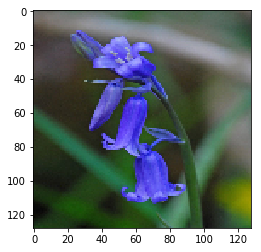

Class probabilities: [1.1446277e-02 9.7440109e-03 9.6723562e-01 1.1214711e-02 3.5941388e-04]
Predicted label: Bluebell

Image 2


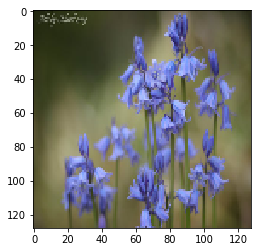

Class probabilities: [7.8946474e-04 2.3674199e-03 9.9021405e-01 6.4020874e-03 2.2705144e-04]
Predicted label: Bluebell

Image 3


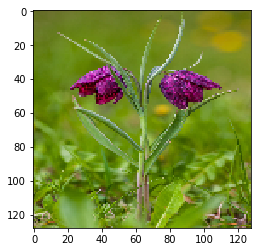

Class probabilities: [0.00819166 0.02640332 0.1250154  0.7962207  0.04416893]
Predicted label: Tiger lily

Image 4


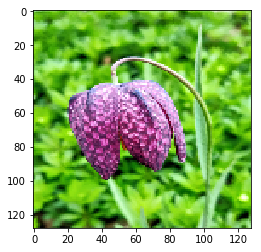

Class probabilities: [0.00436622 0.13273162 0.03389269 0.06388219 0.7651273 ]
Predicted label: Fritillary

Image 5


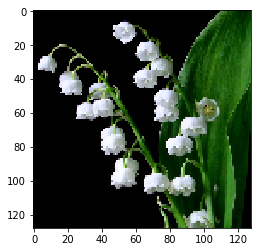

Class probabilities: [0.03865336 0.85089225 0.07787652 0.02839977 0.0041781 ]
Predicted label: Lily valley

Image 6


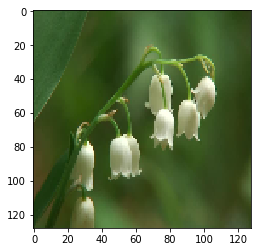

Class probabilities: [0.08352412 0.73129535 0.14276141 0.01779099 0.02462811]
Predicted label: Lily valley

Image 7


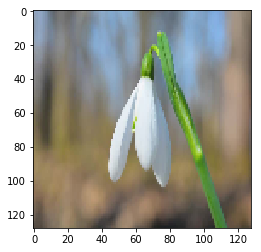

Class probabilities: [0.48906487 0.04654418 0.14472835 0.0383212  0.28134137]
Predicted label: Snowdrop

Image 8


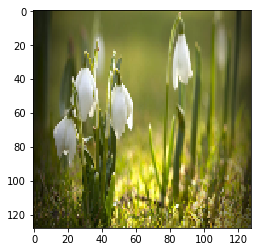

Class probabilities: [0.3570487  0.06714319 0.5455119  0.02814865 0.00214752]
Predicted label: Bluebell

Image 9


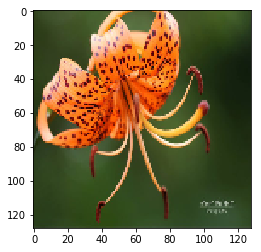

Class probabilities: [0.00779868 0.00334847 0.0624245  0.92033786 0.00609053]
Predicted label: Tiger lily

Image 10


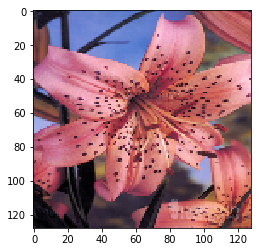

Class probabilities: [0.02441639 0.01633189 0.01018818 0.9300786  0.01898487]
Predicted label: Tiger lily



In [10]:
def predict_test_samples(model):
    samples_dir = "./data/samples"
    # ucitavanje slika iz sample testnog skupa
    sample_images = []
    for img in os.listdir(samples_dir):        
        data_instance = cv2.imread(os.path.join(samples_dir, img))
        data_instance = cv2.cvtColor(data_instance, cv2.COLOR_BGR2RGB)       
        sample_images.append(resize_image(data_instance))
    
    # prilagodjavanje ulaznih slika formatu koji mreza ocekuje
    sample_images = np.array(sample_images).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    # klasifikacija ucitanih slika i prikaz rezultata
    visualize_predictions(model, sample_images)
    
predict_test_samples(model)
